In [10]:
import pandas as pd
from pysam import VariantFile
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

plt.style.use('ggplot')

## Source–[Machine Learning in Bioinformatics: Genome Geography](https://towardsdatascience.com/machine-learning-in-bioinformatics-genome-geography-d1b1dbbfb4c2)

From raw sequencing reads to a machine learning model, which infers an individuals geographical origin based on their genomic variation.

In [3]:
!mkdir vcf; 
!cd vcf
!curl http://hgdownload.cse.ucsc.edu/gbdb/hg38/1000Genomes/ALL.chr1.shapeit2_integrated_snvindels_v2a_27022019.GRCh38.phased.vcf.gz >ALL.chr1.shapeit2_integrated_snvindels_v2a_27022019.GRCh38.phased.vcf.gz
!curl http://hgdownload.cse.ucsc.edu/gbdb/hg38/1000Genomes/ALL.chr1.shapeit2_integrated_snvindels_v2a_27022019.GRCh38.phased.vcf.gz.tbi >ALL.chr1.shapeit2_integrated_snvindels_v2a_27022019.GRCh38.phased.vcf.gz.tbi
!cd ..

mkdir: vcf: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 68  991M   68  676M    0     0   674k      0  0:25:07  0:17:08  0:07:59  250k    0  0:20:47  0:00:20  0:20:27  969k2k      0  0:21:54  0:00:25  0:21:29  607k  0:00:40  0:22:47  675k94k      0  0:24:22  0:00:46  0:23:36  489k10  0:22:05  561k02:24  0:22:06  680k 114M    0     0   711k      0  0:23:46  0:02:44  0:21:02  778k  628k      0  0:26:13  0:04:00  0:22:13  158k 0  0:26:05  0:04:22  0:21:43  878k   0  0:26:03  0:04:23  0:21:40  872k    0  0:24:34  0:05:22  0:19:12  648k  699k      0  0:24:12  0:05:34  0:18:38  939kk      0  0:24:12  0:05:35  0:18:37  898k0:24:11  0:05:37  0:18:34  799k 0:18:23  671k  0  0:24:26  0:06:12  0:18:14  676k38  991k8kk      0  0:23:43  0:07:08  0:16:35  803k3:25  0:07:38  0:15:47  532k  706k      0  0:23:57  0:08:30  0:15:27  495k     0   705k      0  0:23:59  0:08:43  0:15

In [4]:
!mkdir fastq; 
!cd fastq
!curl ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR764/SRR764764/SRR764764_1.fastq.gz >RR764764_1.fastq.gz
!curl ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR764/SRR764764/SRR764764_2.fastq.gz >SRR764764_2.fastq.gz
!cd ..

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0^C
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0^C


# Reduce number of samples using stratified sampling

In [13]:
samples = pd.read_csv('1000genomes_phase3.tsv', sep='\t')
vcf = VariantFile('ALL.chr1.shapeit2_integrated_snvindels_v2a_27022019.GRCh38.phased.vcf.gz')

In [5]:
samples = samples[samples['Sample name'].isin(list(vcf.header.samples))]
samples['Superpopulation code'].value_counts()

NameError: name 'samples' is not defined

In [9]:
samples_subset = samples.groupby('Superpopulation code').apply(lambda x: x.sample(n=20))
samples_subset.reset_index(drop=True, inplace=True)
samples_subset.to_csv('https://github.com/burgshrimps/geogenome/blob/master/samples_subset.tsv', sep='\t', index=False)
num_samples = len(samples_subset)

In [7]:
vcf.subset_samples(list(samples_subset['Sample name']))

# Compute Hamming Distance between subset of samples

In [31]:
num_mismatches = np.zeros((num_samples, num_samples))
num_snps = 0

NameError: name 'num_samples' is not defined

In [9]:
for rec in vcf.fetch():
    all_homref = True
    tmp_mismatches = np.zeros((num_samples, num_samples))
    for i in range(num_samples):
        if rec.samples[i]['GT'] != (0,0):
            all_homref = False
        for j in range(i, num_samples):
            if (rec.samples[i]['GT'] != rec.samples[j]['GT']) & (rec.samples[i]['GT'] != rec.samples[j]['GT'][::-1]):
                tmp_mismatches[i,j] += 1
    if not all_homref:
        num_mismatches += tmp_mismatches
        num_snps += 1

In [10]:
ham_dist = num_mismatches / num_snps
ham_dist = np.triu(ham_dist) + np.tril(ham_dist.T) # Make matrix balanced
np.savetxt('ham_dist.txt', ham_dist, delimiter='\t', fmt='%1.3f')

In [9]:
!pip install pysam

  Using cached pysam-0.16.0.1.tar.gz (3.6 MB)
  Created wheel for pysam: filename=pysam-0.16.0.1-cp39-cp39-macosx_10_9_x86_64.whl size=2474136 sha256=881f249c8f202ad822b0ce98ba73ac62f8b13bdbfb6f7dc1f4f1c420b8b98a7f
  Stored in directory: /Users/caleb/Library/Caches/pip/wheels/fb/96/5b/d62b12ccae437c41f0368bca424aa34b6d3f9fef4a38640edc
Successfully built pysam


# Load pre-computed files

In [14]:
vcf = VariantFile('http://hgdownload.cse.ucsc.edu/gbdb/hg38/1000Genomes/ALL.chr1.shapeit2_integrated_snvindels_v2a_27022019.GRCh38.phased.vcf.gz')
samples_subset = pd.read_csv('https://raw.githubusercontent.com/burgshrimps/geogenome/master/samples_subset.tsv', sep='\t')
ham_dist = np.loadtxt('https://raw.githubusercontent.com/burgshrimps/geogenome/master/ham_dist.txt')

In [15]:
vcf.subset_samples(list(samples_subset['Sample name']))

In [16]:
sorterIndex = dict(zip(list(vcf.header.samples), range(len(list(vcf.header.samples)))))
samples_subset['Rank'] = samples_subset['Sample name'].map(sorterIndex)
samples_subset.sort_values('Rank', inplace=True)
samples_subset.drop('Rank', axis=1, inplace=True)

In [17]:
df = pd.DataFrame(ham_dist)

In [18]:
df[['sample', 'superpop', 'pop']] = samples_subset[['Sample name', 'Superpopulation code', 'Population code']].reset_index(drop=True)

In [19]:
df = df.rename(columns=dict(zip(range(100), list(samples_subset['Sample name']))))
df = df.set_index('sample')

# Plot Heatmap of Hamming Distances

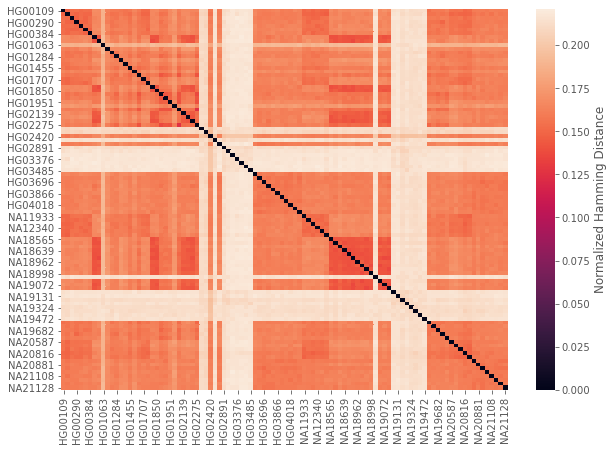

In [20]:
plt.figure(figsize=(10,7))
sns.heatmap(df.drop(['superpop', 'pop'], axis=1), cbar_kws={'label': 'Normalized Hamming Distance'})
plt.ylabel('')
plt.show()

# Dimensionality Reduction with tSNE

In [21]:
tsne = TSNE(n_components=2)

In [22]:
transformed = tsne.fit_transform(df.drop(['superpop', 'pop'], axis=1))

In [23]:
df_tsne = pd.DataFrame(transformed, columns=['C1', 'C2'])
df_tsne[['superpop', 'pop']] = df[['superpop', 'pop']].reset_index(drop=True)

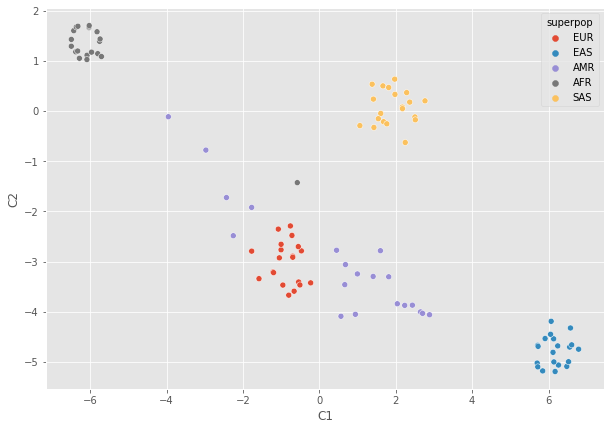

In [24]:
plt.figure(figsize=(10,7))
sns.scatterplot(x='C1', y='C2', data=df_tsne, hue='superpop')
plt.show()

# Multinomial Classification

In [25]:
X, y = df.drop(['superpop', 'pop'], axis=1), df['superpop']

In [26]:
rf = RandomForestClassifier()
nb = MultinomialNB()
knn = KNeighborsClassifier()
lgr = LogisticRegression(multi_class='multinomial')

In [27]:
classifiers = [rf, nb, knn, lgr]
scores = np.array([])
k = 5
for clf in classifiers:
    scores = np.append(scores, cross_val_score(clf, X, y, cv=k)[:])
classifier_labels = []
for label in ['RF', 'NB', 'KNN', 'LGR']:
    classifier_labels += [label] * k

In [30]:
scores

array([0.95, 1.  , 1.  , 0.95, 1.  , 0.85, 0.85, 1.  , 0.9 , 0.85, 0.85,
       0.9 , 1.  , 1.  , 0.95, 0.8 , 0.85, 0.8 , 0.85, 0.8 ])

In [28]:
df_scores = pd.DataFrame([scores, classifier_labels], index=['Accuracy', 'Classifier'])
df_scores = df_scores.T

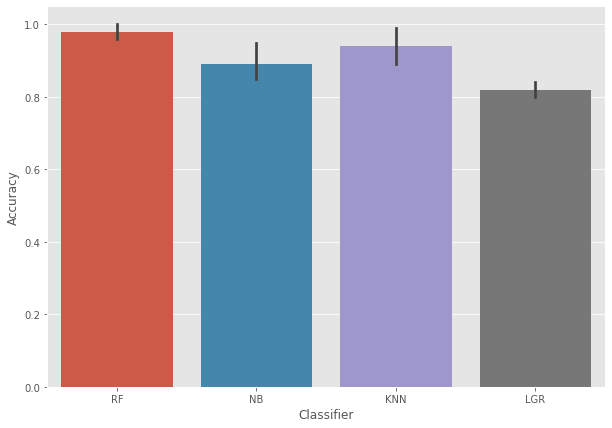

In [29]:
plt.figure(figsize=(10,7))
sns.barplot(x='Classifier', y='Accuracy', data=df_scores)
plt.show()